# Wczytywanie danych medycznych
Opracowanie: A.Florkowska

In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import Image

# Co to jest DICOM?
DICOM to standardowy format używany do zapisywania, przechowywania, czy przesyłania medycznych danych obrazowych, takich jak MRI czy CT. 

Standard DICOM definiuje sposób kodowania danych obrazowych i metadanych (informacje o pacjencie protkoły badania, informacje o urządzeniu etc). Zapewnia to zachowanie spójności zapisu, przy jednoczesnym użytkowaniu sprzętu od różnych dostawców.

Co więcej, DICOM to obrazy 16-bitowe (z wartościami w zakresie od -32768 do 32767), podczas gdy obrazy 8-bitowe w skali szarości przechowują wartości tylko z zakresu od 0 do 255. 

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: 0aef8620785f
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice Thickness                     DS: '1.25'
(0018, 0060) KVP                                 DS: '120.0'
(0018, 1120) Gantry/Detector Tilt                DS: '0.0'
(0018, 1130) Table Height                        DS: '172.5'
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1151) X-Ray Tube Current                  IS: '747'
(0018, 1152) Exposure                            IS: '6'
(0018, 1210) Convolution Kernel                  SH: 'STANDARD

C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '80e30f500244'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '0aef8620785f'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '00268ff88746'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '75d23269adbd'. Please see <https:/

Text(0.5, 1.0, 'CT')

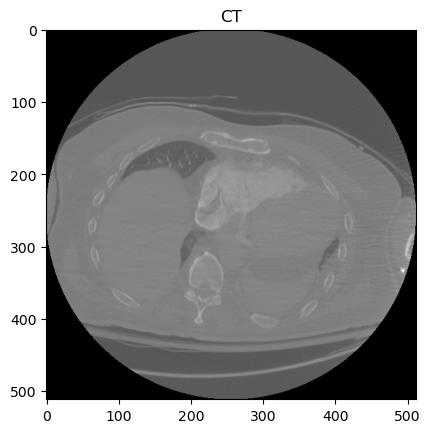

In [2]:
imageCT = pydicom.read_file(".././images/example2.dcm")
print(imageCT)

plt.imshow(imageCT.pixel_array, cmap='gray')
plt.title("CT")

# Tomografia komputerowa

Podczas pracy z danymi z tomografii komputerowej (CT) kluczowe znaczenie ma odpowiednie zrozumienie tego co te dane właściwie przedstawiają. 

Tomografia komputerowa to metoda diagnostyczna wykorzystujące promieniowanie rentgenowskie w celu uzyskania wielowarstkowych, przekrojowych obrazów ciała. Promieniowanie rentgenowskie (inaczej X) to rodzaj promieniowania elektromagnetycznego, które jest generowane podczas wyhamowywania elektronów (ogrzana katoda uwalnia elektrony o wysokiej energii, które z kolei uwalniają swoją energię w postaci promieniowania rentgenowskiego). Promienie rentgenowskie przechodzą przez tkanki i uderzają w detektor po drugiej stronie, z tym, że różne tkanki absorbują różne ilości promieniowania. 

Ogólna zasada jest taka: im gęstsza jest tkanka, tym więcej pochłania promieni rentgenowskich. Przykładowo, kość pochłania ich dużo, na detektor dociera mała ilość promieniowania co przekłada się na obraz biały. Z kolei powietrze nie pochłania tego promieniowania, innymi słowy duża ilość promieniowania dociera do detektora co przekłada się na obraz czarny.

Obecne wykorzystywane są urządzenia spiralnej tomografii komputerowej. Taka maszyna składa się z pojedynczego źródła promieniowania z wieloma detektorami, które obracają się wokół pacjenta, uzyskując blok danych w miarę przemieszczania wokół niego. Uzyskane informacje można zrekonstruować komputerowo w celu utworzenia „objętości” 3D, którą można następnie „pociąć” cyfrowo w celu uzyskania cieńszych przekrojów, a także przekrojów w różnych płaszczyznach anatomicznych: czołowa (coronal), strzałkowa (sagital) i poprzeczna (axial). 

Obrazowanie metodą tomografii komputerowej pozwala na uzyskanie obrazów strukturalnych, takich jak kości i tkanki miękkie. W efekcie, dane z CT przedstawiają gęstość radiologiczną, wyrażona w jednostkach skali Hounsfielda (HU). 

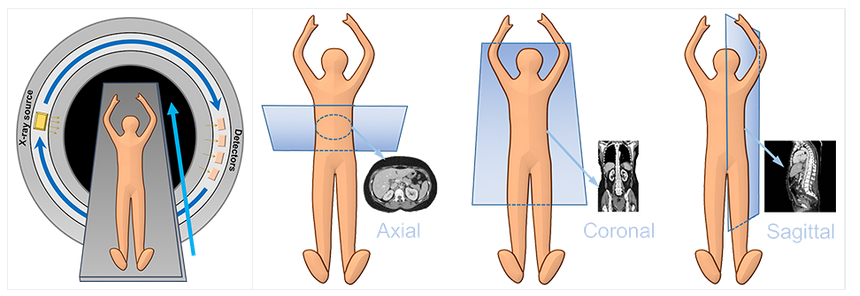

In [8]:
Image(filename=".././images/9_2.png", width=800)
# Source: https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained

# Skala Hounsfielda

Skala jednostek Hounsfielda jest liniowym przekształceniem pierwotnego pomiaru liniowego współczynnika osłabienia, w której gęstość radiologiczna wody destylowanej w standardowej temperaturze i ciśnieniu (warunki standardowe) jest definiowana jako 0 HU, natomiast gęstość powietrza w warunkach standardowych jest określana jako -1000 HU. 

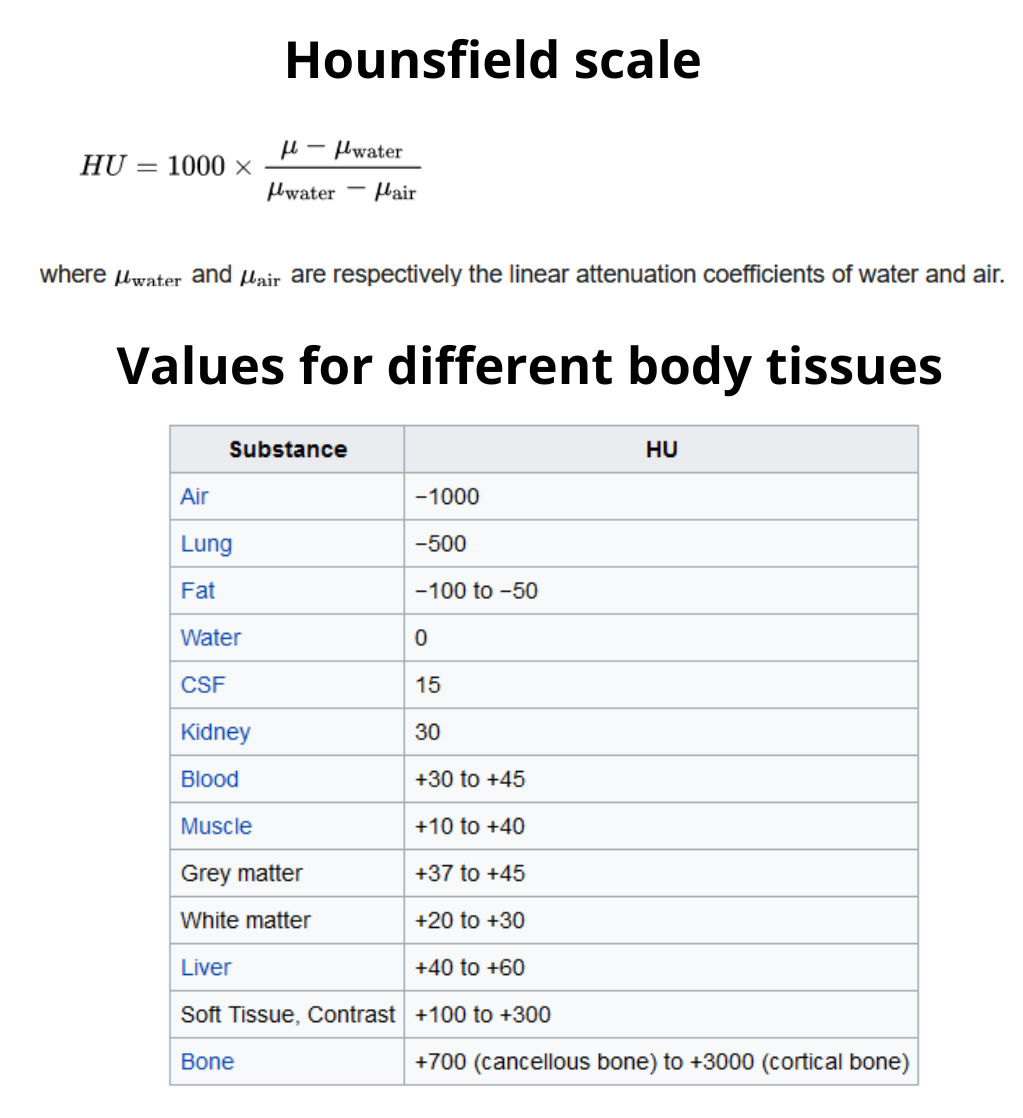

In [13]:
Image(filename=".././images/9_1.png", width=500)
# Source: https://en.wikipedia.org/wiki/Hounsfield_scale

# Konwersja wartości do jednostek w skali Hounsfielda

Wspomniane wcześniej zakresy wartości w DICOM są przydatne, ponieważ korelują ze skalą Hounsfielda. Na początku należy wartości pikseli przekształcić na odpowiadające jednostki w skali Hounsfielda. W obliczeniach wykorzystuje się z 2 tagi z metadanych pliku DICOM:  mnoży się wartości przez nachylenie (RescaleSlope) oraz dodaje punkt przecięcia (RescaleIntercept).

Niektóre skanery mają cylindryczne granice skanowania, jednakże ich obraz wyjściowy jest kwadratowy. Piksele wykraczające poza te granice otrzymują stałą wartość -2000. Jako, że wartość punktu przecięcia (RescaleIntercept) wynosi zazwyczaj -1024 a nachylenie (RescaleSlope) 1, to wartość powietrza odpowiada średnio wartości 0. Właśnie na taką wartośc ustawia się wartości poza tymi granicami skanowania.

Poniżej przedstawiono histogramu wczytanego obrazu DICOM. 

Text(0.5, 1.0, 'Histogram')

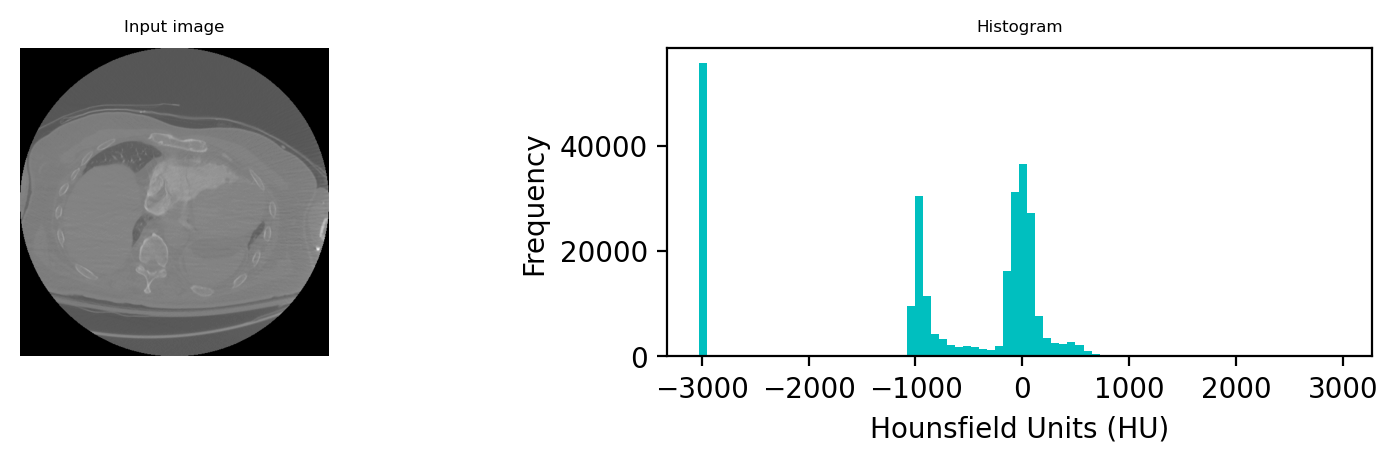

In [5]:
image = (imageCT.pixel_array).astype(np.int16)
image  = image.astype(float) * imageCT.RescaleSlope 
image = image.astype(np.int16) + np.int16(imageCT.RescaleIntercept)

plt.figure(figsize=(10, 2), dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(imageCT.pixel_array, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 2, 2)
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.title("Histogram", fontsize=6)

# def apply_ct_window(img, window):
#     # window = (window width, window level)
#     R = (img-window[1]+0.5*window[0])/window[0]
#     R[R<0] = 0
#     R[R>1] = 1
#     return R
# display_img = apply_ct_window(image, [400,50])
# plt.imshow(display_img, cmap='gray')

# Resampling - ponowne próbkowanie

Dane zapisane w formacie DICOM zawierają wiele metadanych m.in. informacje o grubości piksela (slice thickness) oraz odległości między kolejnymi pikselami (pixel spacing). W praktyce może się zdarzyć, że wartości tych tagów są zależne od skanów, co może negatywnie wpłynać na wydajność np. podczas analizy przy użyciu konwolucyjnych sieci neuronowych. Na szczęście można temu zaradzić, poprzez ponownie próbkowanie, zazwyczaj do rozmiarów 1 mm x 1mm x 1mm.

In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


# Normalizacja

# Centralizacja do 0

# Źródła
- Wyjaśnione okienkowanie: https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained
- Pełen tutorial wstępnego przetworzenia danych: https://www.kaggle.com/code/joncarlisle/full-preprocessing-tutorial